## 1. Einleitung

Welche Wörter wir benutzen um etwas auszudrücken sagt nicht nur etwas über unsere [politische Orientierung](https://nbviewer.jupyter.org/github/tburst/Projects/blob/master/Politische%20Sprache/Klassifikation%20politischer%20Sprache/Klassikfikation_politischer_Sprache.ipynb) aus, sondern zeigt auch, mit welcher Wertung wir über das Angesprochene denken. Stehen wir dem Sachverhalt positiv gegenüber, verwenden wir Worte, die positive "Sentiments" ausdrücken (naheliegende Beispiele sind Adjektive wie "gut" oder "perfekt"), bei einer negativen Einstellung finden Worte wie "schlecht" oder "schrecklich" Verwendung.  

In der Politik spielt diese klare Positionierung mittels Sprache eine besondere Rolle. Im Wettstreit mit anderen politischen Richtungen und entlang der Konfliktlinie zwischen Regierung und Opposition werden Entscheidungen anders bewertet, Themen unterschiedlich besprochen und besetzt und eher positive oder negative Ereignisse aufgegriffen und in die Diskussion eingebracht.

Im Folgenden widme ich mich diesem Sachverhalt näher. Dafür greife ich auf ein deutsches Sentimentwörterbuch zurück, kombiniere es mit der Fähigkeit des Word2Vec-Modells, die Semantik eines Wortes abzubilden und trainiere mittels dieses Trainingsdatensatzes eine Support Vector Machine, um ein eigenes, speziell für den Politikbereich geeignetes Sentimentwörterbuch zu erstellen. Im einzelnen sieht das Vorgehen folgendermaßen aus:

* Zunächst nutze ich ein bereits vorhandenes deutsches Sentimentwörterbuch, um ein Grundvokabluar an deutschen Worten zu erhalten, die eine positive oder negative Einstellung ausdrücken.
* Danach kommt der Word2Vec-Algorithmus von Google zum Einsatz, um ein Word2Vec-Modell mittels  47.070 Bundestagsreden zu trainieren. Da ausschließlich politische Texte genutzt werden, bildet das Modell die Semantik der Worte ab, die sie speziell im politischen Kontext innehaben.  
* Im dritten Schritt merge ich die bereits vorhandenen Wörter aus dem Sentimentwörterbuch mit ihren Wortvektoren aus dem Word2Vec-Modell. Dadurch erhalte ich einen Datensatz, der Wörter mit eindeutiger Sentimentwertung (positiv/negativ) und zugeordneten Wortvektoren enthält.
* Mittels dieses Datensatzes wird eine Support Vector Machine lernen, das positive/negative Sentiment eines Wortes anhand des Wortvektors vorherzusagen. 
* Das Modell wird dann dafür genutzt, die Sentiments für das restliche Vokabular des Word2Vec-Modells zu bestimmen. Dadurch erhalten wir ein neues, auf den Politikbereich spezialisiertes Sentimentwörterbuch.
* Zum Abschluss demonstriere ich einige potentielle Anwendungsmöglichkeiten dieser neu erstellten Sentimentressource und zeige unter anderem die klare Trennung zwischen Regierungs- und Oppositionssprache, die sich in den Sentiments der Reden widerspiegelt.

## 2. Vorbereitung

### 2.1 Laden von Sentimentwörtern und des Word2Vec-Modells

Als Basis für alles weitere benötigen wir zunächst eine Grundlage an Wörtern, für die ihr Sentiment, also die Wertung, die sie enthalten, feststeht. Dafür greife ich auf die drei Datensätze von [GermanPolarityClues](http://www.ulliwaltinger.de/sentiment/)...

In [1]:
import pandas as pd

pd.set_option("display.max_columns",6)

negative_df = pd.read_csv("GermanPolarityClues-Negative-21042012.tsv", sep="\t", 
                          names=["Wort","Lemma","PoS","Polarity","Probability","Class"])
positive_df = pd.read_csv("GermanPolarityClues-Positive-21042012.tsv", sep="\t", 
                          names=["Wort","Lemma","PoS","Polarity","Probability","Class"])
neutral_df =  pd.read_csv("GermanPolarityClues-Neutral-21042012.tsv", sep="\t", 
                          names=["Wort","Lemma","PoS","Polarity","Probability","Class"])

... und eine Sentimentliste von [Josef Ruppenhofer, Petra Steiner und Michael Wiegand](https://github.com/josefkr/morphcomp) zurück.

In [2]:
morph_polarity_df = pd.read_csv(r"Morph-Polarity\morphcomp-master\train_test_lemma_polarity.txt", sep="\t", 
                                names=["Wort","Polarity"])

In [3]:
morph_polarity_df["Wort"] =  [row.split("_")[0] for row in morph_polarity_df["Wort"]]

polarity_dict = {"NEG": "negative", "POS": "positive", "NEU": "neutral", "SHI": "SHI", "INT": "INT"}
morph_polarity_df["Polarity"] =  [polarity_dict[row] for row in morph_polarity_df["Polarity"]]

Beispielhaft ist hier ein Auszug aus dem negativen Sentiment Datensatz zu sehen. Für uns interessant sind die "Wort" und die "Polarity" Spalten.

In [4]:
negative_df.head()

,Wort,Lemma,PoS,Polarity,Probability,Class
0,Abandon,Abandon,NN,negative,-/-/-,D
1,Abart,Abart,NN,negative,-/-/-,D
2,Abbau,Abbau,NN,negative,-/-0.058/-,L
3,Abbaue,Abbau,NN,negative,-/-0.058/-,L
4,Abbauen,Abbau,NN,negative,-/-0.058/-,L


Außerdem benötigen wir ein Word2Vec-Modell, um die Worte mittels bedeutungstragenden Vektoren abzubilden. Es exisitieren bereits eine Reihe von guten Erklärungen, was ein Word2Vec-Modell genau ist (z.B. [hier](http://multithreaded.stitchfix.com/blog/2015/03/11/word-is-worth-a-thousand-vectors/) oder [hier](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/)). Vereinfacht gesagt lernt das Modell die Bedeutung eines Wortes, indem es die umgebenden Worte betrachtet. Jedes Wort wird so als Vektor abgebildet und diese Vektoren werden mit jedem Satz, den das Modell im Trainingsprozess betrachtet, angepasst, sodass Worte, die in ähnlichem Kontext vorkommen, nach und nach ähnliche Vektoren aufweisen bzw. im Vektorraum nahe beieinander liegen.

Um mit einem Word2Vec-Modell arbeiten zu können, gibt es zum einen die Möglichkeit, ein bereits vortrainiertes Modell zu nutzen. Diese werden in der Regel anhand einer großen Menge an News- und/oder Wikipedia-Artikel trainiert. In unserem Fall jedoch bietet ein selbst trainiertes Word2Vec-Modell den Vorteil, dass es die Bedeutung von Wörtern nur mittels des Bundestagsreden-Korpus abbildet, wodurch sich ein Modell mit Spezialisierung auf das politische Vokabular und spezifische politische Bedeutungsgehälter ergibt.

Mittels der "gensim" Library laden wir unser eigenes, bereits trainiertes Word2Vec-Modell.

In [5]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import gensim

word2vec_model = gensim.models.Word2Vec.load('word2vec_300dims_iter20_47467speeches_window10')

Um die Möglichkeiten zu demonstrieren, die so ein Word2Vec-Modell bietet, zeige ich ein paar mögliche direkte Anfragen an das Modell. 

Hier sind beispielsweise die 15 Worte, die dem Modell nach semantisch am ähnlichsten zu dem Wort "Islamismus" sind

In [6]:
word2vec_model.most_similar('islamismus', topn=15)

[('extremismus', 0.7211811542510986),
 ('rechtsradikalismus', 0.6909369230270386),
 ('linksextremismus', 0.6883890628814697),
 ('fundamentalismus', 0.676803469657898),
 ('antisemitismus', 0.6545290946960449),
 ('rechtsextremismus', 0.6270365715026855),
 ('islamistischen', 0.6108469367027283),
 ('salafismus', 0.609311580657959),
 ('islam', 0.6016819477081299),
 ('rassismus', 0.5997992157936096),
 ('terrorismus', 0.5939330458641052),
 ('fanatismus', 0.5838288068771362),
 ('rechtsterrorismus', 0.5834563970565796),
 ('ausländerfeindlichkeit', 0.5796167850494385),
 ('intoleranz', 0.5788671970367432)]

Es ist beeindruckend, wie gut das Modell lernt, die Bedeutung von Wörtern mittels deren Kontext abzubilden und bei dem Finden von Ähnlichkeiten Wörter, die unterschiedlichen Bezug zu dem Suchwort haben, zusammenbringt. Hier findet es zum einen weitere radikale/extremistische politische Richtungen, jedoch auch den allgemeinen religiösen Bezug ("islam") und allgemeinere Begrifflichkeiten ("terrorismus","gewaltbereiten").

In [7]:
word2vec_model.most_similar(positive=["kuba"], topn=15)

[('myanmar', 0.6290006637573242),
 ('kolumbien', 0.6145118474960327),
 ('venezuela', 0.6108405590057373),
 ('china', 0.5977751612663269),
 ('simbabwe', 0.5958115458488464),
 ('weißrussland', 0.5828683376312256),
 ('ägypten', 0.5790112018585205),
 ('usbekistan', 0.5741658210754395),
 ('belarus', 0.5722464323043823),
 ('lateinamerika', 0.5722249746322632),
 ('birma', 0.5653955936431885),
 ('honduras', 0.5618592500686646),
 ('tibet', 0.5604021549224854),
 ('russland', 0.5543767213821411),
 ('südafrika', 0.5376547574996948)]

Das Modell gibt gefragt nach ähnlichen Wörtern zu Kuba nachvollziehbarerweise andere Länder zurück. Warum gerade Myanmar die größte semantische Nähe zu Kuba aufweist lässt natürlich Interpretationsspielraum. Festzuhalten ist aber, dass in den Bundestagsdiskussionen der 14.-18. Wahlperiode Kuba als Wort in ähnlichen Kontexten verwendet wurde, wie Myanmar, Kolumbien oder auch Venezuela.  

### 2.2 Merging von Wortvektoren mit Sentimentwörtern

Um das Word2Vec-Modell mit den vordefinierten Sentimentwörtern zusammenzubringen erstellen wir eine Funktion, die Zeile für Zeile unsere drei Sentiment-Datensätze durchgeht, überprüft ob das jeweilige Wort auch in dem Vokabular des Word2Vec-Modells vorkommt und falls ja, den zugehörigen Wordvektor abspeichert. Am Ende gibt die Funktion einen neuen Dataframe wieder, der alle Wörter mit zugehörigem Wordvektor enthält.

In [8]:
def get_word2vec_for_sentimentwords(df,word2vec_model):
    word_vector_dict = {}
    for row in df.iterrows():
        #iterrows gibt für jede Zeile einen Tuple von der Art (Zeilenindex,(Alle Daten der Zeile)) wieder
        index = row[0]
        word = row[1][0].lower()
        if word in word2vec_model.wv.vocab:
            single_word_vectors_dict = {}
            word_vector = word2vec_model[word]
            for vector_index,value in enumerate(word_vector):
                single_word_vectors_dict["Vector_" + str(vector_index)] = value
            word_vector_dict[index] = single_word_vectors_dict
    word_vector_df = pd.DataFrame.from_dict(word_vector_dict,orient="index")
    return word_vector_df

    

Die Funktion wenden wir dann auf alle vier Sentiment-Datensätze an.

In [9]:
positive_word_vector_df = get_word2vec_for_sentimentwords(positive_df, word2vec_model)
negative_word_vector_df = get_word2vec_for_sentimentwords(negative_df, word2vec_model)
neutral_word_vector_df = get_word2vec_for_sentimentwords(neutral_df, word2vec_model)
morph_polarity_vector_df = get_word2vec_for_sentimentwords(morph_polarity_df, word2vec_model)

Danach werden die vier neuen Datensätze, die die Wortvektoren enthalten, mit den ursprünglichen drei, die Sentimentwertungen enthaltenden, Datensätzen zusammengefügt.

In [10]:
merged_positive_df = positive_df.merge(positive_word_vector_df, how="inner",right_index=True,left_index=True)
merged_negative_df = negative_df.merge(negative_word_vector_df, how="inner",right_index=True,left_index=True)
merged_neutral_df = neutral_df.merge(neutral_word_vector_df, how="inner",right_index=True,left_index=True)
merged_morph_polarity_df = morph_polarity_df.merge(morph_polarity_vector_df, how="inner",right_index=True,left_index=True)

In [11]:
merged_positive_df.head()

,Wort,Lemma,PoS,...,Vector_291,Vector_86,Vector_95
3,Abgleich,Abgleich,NN,...,-0.691909,-0.435301,-0.413289
5,Abhilfe,Abhilfe,NN,...,-2.185567,-0.089397,-2.717793
8,Abkommen,Abkomme,NN,...,-1.359522,0.231967,1.565425
9,Abkühlung,Abkühlung,NN,...,-0.025438,-0.190076,-0.429547
10,Ableger,Ableger,NN,...,0.230129,0.120202,-0.402528


In [12]:
merged_positive_df.shape

(5531, 306)

Durch die Wordvektoren sind 300 Kolumnen hinzugekommen.

Im nächsten Schritt erstellen wir aus den vier in positive, neutrale und negative aufgeteilte Dataframes einen einzelnen großen Datensatz. Dieser wird dann als Trainingsdatensatz für das Machinelearning-Modell dienen.

### 2.3 Erstellung des finalen Trainingsdatensatzes

Da alle vier Datensätze die gleichen Kolumnen in gleicher Reihenfolge aufweisen können wir ihre Zeilen einfach untereinander zusammenfügen. 

In [13]:
merged_positive_df.drop(["Lemma","PoS","Probability","Class"],axis = 1, inplace=True)
merged_neutral_df.drop(["Lemma","PoS","Probability","Class"],axis = 1, inplace=True)
merged_negative_df.drop(["Lemma","PoS","Probability","Class"],axis = 1, inplace=True)


final_merged_df = merged_positive_df.append(merged_negative_df)
final_merged_df = final_merged_df.append(merged_neutral_df)
final_merged_df = final_merged_df.append(merged_morph_polarity_df)

In [14]:
final_merged_df.drop_duplicates(subset="Wort", keep='first', inplace=True)

Bevor mit dem Trainieren des Machinelearning-Modells begonnen werden kann fehlt noch eine Kolumne, die das Vorhersageziel des Modells abbildet und anhand dessen es lernt, die unterschiedlichen Sentiments der Wörter zu unterschieden. Dafür gibt es mehrere Möglichkeiten:

Zum einen wäre es denkbar, die Frage nach der Sentimentwertung der Wörter als Regressionsproblem aufzufassen. In unserem Fall könnten wir einem negativen Wort eine Wertung von -1, einem neutralen Wort 0 und einem positiven Wort eine 1 als Wertung zuordnen und ein Regressionsmodell trainieren, um mittels der Wordvektoren eine Wertung für noch unbekannte Worte zu erhalten. Dies hätte den Vorteil, dass durch das Modell Unterscheidungen zwischen den Wörtern innerhalb der einzelnen Kategorien getroffen werden könnten: Bspw. haben möglicherweise zwei positive Wörter nicht unbedingt die gleiche positive Bedeutung. Während das eine nur schwach positiv wirkt, ist das andere vielleicht ein sehr positives Wort mit starker Signalwirkung. Ein Regressionsmodell könnte dem ersten Wort eine schwächere Wertung (z.B. 0,7) und dem anderen eine stärkere Wertung zusprechen (1,5) und würde so der Komplexität von Sprache möglicherweise etwas grechter. Allerdings enthält unser Trainingsdatensatz keine Sentimentwertung sondern nur die allgemeine Zuordnung zu positiv, neutral oder negativ. Dementsprechend ist fraglich, wie gut ein Modell auf Basis der von uns künstlich zugeordneten 1,0,-1 Wertungen wirklich die Differenzierung in unterschiedliche Wertungen lernen würde und wie verlässlich die zugeordneten Wertungen tatsächlich wären.

Eine andere Herangehensweise wäre ein Klassifikationsmodell mit mehreren Klassen zu bilden, also ein einzelnes Modell, das ein Wort entweder der positiven, der neutralen oder der negativen Klasse zuordnet. Das bietet den Vorteil, dass nur ein einzelnes Modell für das weitere Vorgehen benötigt wird. Da jedoch nur wenige Beispielwörter für die neutrale Klasse zur Verfügung stehen ist der Datensatz in dieser Hinsicht sehr unausbalanciert. Die Evaluation eines solchen Modells erreichte dementsprechend auch eine im Vergleich zur im nächsten Punkt genannten Alternative geringere Genauigkeit.

Die dritte Option, für die ich mich im folgenden auch entschieden habe, ist das Problem in mehrere binäre Klassifikationsprobleme aufzuteilen und jeweils ein Modell für die Fragen "ist ein Wort positiv oder nicht?" und "ist ein Wort negativ oder nicht?" zu bilden. Bei dieser Methode haben wir einen ausgeglichenen Datensatz zur Verfügung und das Modell muss die weniger komplexe Frage abbilden, ob ein Wort zu einer Klasse zugehörig ist oder nicht, ohne eine Differenzierung in weitere Klassen vornehmen zu müssen.





Dafür werden zunächst zwei Funktionen erstellt, die mittels der pandas "apply" Methode neue Kolumen für die positive und die negative Klasse hinzufügen.

In [15]:
def positive_sentiment(df):
    return df['Polarity'] == "positive"

def negative_sentiment(df):
    return df['Polarity'] == "negative"

final_merged_df["Positive_Sentiment_Class"] = final_merged_df.apply(positive_sentiment, axis=1)
final_merged_df["Negative_Sentiment_Class"] = final_merged_df.apply(negative_sentiment, axis=1)

In [16]:
final_merged_df.head()

,Wort,Polarity,Vector_15,...,Vector_95,Positive_Sentiment_Class,Negative_Sentiment_Class
3,Abgleich,positive,-1.216724,...,-0.413289,True,False
5,Abhilfe,positive,2.112006,...,-2.717793,True,False
8,Abkommen,positive,-0.686645,...,1.565425,True,False
9,Abkühlung,positive,0.057390,...,-0.429547,True,False
10,Ableger,positive,-0.305684,...,-0.402528,True,False


Insgesamt steht uns also ein Datensatz mit 14143 Wörtern und 300 Features (den Vektorzahlen) zur Verfügung.

In [17]:
final_merged_df.shape

(14143, 304)

## 3. Modelltraining

Jetzt sind wir in der Lage unser Modell zu trainieren. Hierfür greife ich auf eine Support Vector Machine mit "rbf" Kernel zurück, die im Vergleich zu anderen Modellarten deutlich besser mit den Wordvektoren als Features zurechtkam und die besten Ergebnisse erzielte.

Zunächst das Modell zur Bestimmung von positiven Wörtern.

### 3.1 Modell für positive Sentiments

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


start_column = final_merged_df.columns[2]
end_column   = final_merged_df.columns[len(final_merged_df.columns) - 3]

X = final_merged_df.loc[:,start_column :end_column]
y = final_merged_df["Positive_Sentiment_Class"]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

svc_cl_positiv = SVC(C=1.5,cache_size=2000,probability=True)
svc_cl_positiv = svc_cl_positiv.fit(X_train,y_train)
svc_cl_positiv.score(X_test,y_test)

0.80556210228611835

In [19]:
from sklearn.metrics import classification_report

predicted = svc_cl_positiv.predict(X_test)
predicted_prob = [prob[1] for prob in svc_cl_positiv.predict_proba(X_test)]
print(classification_report(y_test, predicted))

             precision    recall  f1-score   support

      False       0.80      0.88      0.84      2397
       True       0.82      0.70      0.76      1846

avg / total       0.81      0.81      0.80      4243



Es erreicht bei den zurückbehaltenen Testdaten eine Genauigkeit von  80,5%. Das heisst mit 80,5% Genauigkeit kann das Modell anhand des Vektors eines Wortes vorhersagen, ob es sich um ein positiv besetztes Wort handelt oder nicht. Ein erstaunlich gutes Ergebnis, das aufzeigt, wie gut Wortvektoren die Bedeutung (und damit auch das transportierte Sentiment) eines Wortes abbilden.

Es liegt in der Natur der Sache, dass uns vor allem daran gelegen ist, die Anzahl an false positives möglichst klein zu halten. In unserer finalen Liste an positiven und negativen Wörtern sollten auch tatsächlich fast ausschließlich positiv bzw. negativ besetzte Wörter auftauchen. Dementsprechend experimentieren wir nachfolgend mit unterschiedlichen Entscheidungs-Thresholds, nach denen eine Zuordnung zu der gesuchten Klasse stattfindet, um unseren precision Wert möglichst zu maximieren.

In [20]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
confusion_matrix(y_test, predicted)

array([[2117,  280],
       [ 545, 1301]], dtype=int64)

Mit einem default Threshold von 0.5 haben wir insgesamt 280 Wörter fälschlich als positives Sentiment klassifiziert, das macht bezogen auf alle positive sentiment Zuordnungen durch das Modell immerhin einen Anteil von 17,7% aus.

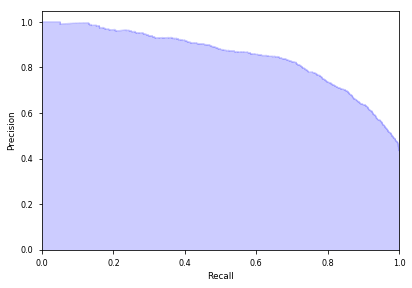

In [21]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

matplotlib.style.use('seaborn-paper')

precision, recall, thresholds = precision_recall_curve(y_test, predicted_prob)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')



In [22]:
positive_precision_df = pd.DataFrame()

positive_precision_df["Precision"] = precision[:-1]
positive_precision_df["Recall"] = recall[:-1]
positive_precision_df["Threshold"] = thresholds

positive_precision_df[positive_precision_df["Precision"] >= 0.95].head()

,Precision,Recall,Threshold
3636,0.950820,0.282774,0.870032
3637,0.950730,0.282232,0.870267
3638,0.950640,0.281690,0.870374
3639,0.952381,0.281690,0.870456
3640,0.952294,0.281148,0.870549


Um einen Precision Wert von wenigstens 95% zu erreichen muss ein Entscheidungstreshold von knapp 0.87 gesetzt werden. Damit würden letztlich nur noch 5% der Wörter in der finalen Liste nicht zur positiven Sentimentklasse gehören, obwohl sie dort eingeordnet wurden. Gleichzeitig erhält dieser Threshold einen Recall-Wert von immerhin noch 28%, sodass noch eine ausreichende Menge an postiven Wörtern ihren Weg in die finale Liste finden.

### 3.2 Modell für negative Sentiments

Das gleiche machen wir noch für die negative Sentiment Klasse.

In [23]:
X = final_merged_df.loc[:,start_column :end_column]
y = final_merged_df["Negative_Sentiment_Class"]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

svc_cl_negativ = SVC(C=1.5,cache_size=2000,probability=True)
svc_cl_negativ = svc_cl_negativ.fit(X_train,y_train)
svc_cl_negativ.score(X_test,y_test)

0.81216120669337732

In [24]:
predicted = svc_cl_negativ.predict(X_test)
predicted_prob = [prob[1] for prob in svc_cl_negativ.predict_proba(X_test)]
print(classification_report(y_test, predicted))

             precision    recall  f1-score   support

      False       0.81      0.83      0.82      2164
       True       0.82      0.79      0.81      2079

avg / total       0.81      0.81      0.81      4243



In [25]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
confusion_matrix(y_test, predicted)

array([[1800,  364],
       [ 433, 1646]], dtype=int64)

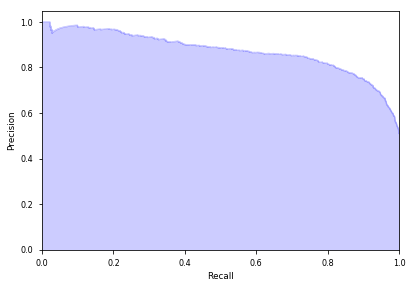

In [26]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib


precision, recall, thresholds = precision_recall_curve(y_test, predicted_prob)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')



In [27]:
negative_precision_df = pd.DataFrame()

negative_precision_df["Precision"] = precision[:-1]
negative_precision_df["Recall"] = recall[:-1]
negative_precision_df["Threshold"] = thresholds

negative_precision_df[positive_precision_df["Precision"] >= 0.95].head()

C:\Users\burst\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Precision,Recall,Threshold
3636,0.968992,0.180375,0.957203
3637,0.968912,0.179894,0.957224
3638,0.968831,0.179413,0.957378
3639,0.968750,0.178932,0.957424
3640,0.968668,0.178451,0.957435


Das Modell für die negativen Sentiments erreicht (wenig überraschend)  auch eine Genauigkeit von ca. 81%. Um hier auf einen aktzeptablen Precision-Wert von wenigstens 95% zu kommen muss der Threshold Wert etwas höher angesetzt werden, als bei dem Modell für positive Sentiments. 

### 3.3 Finale Sentimentsmodelle

Nach der Leistungsbestimmung der Modelle können nun die beiden finalen Modelle anhand des gesamten Trainingsdatensatzes trainiert werden. Wichtig ist auch hier, dass wir dem Modell probabilistische Aussagen über die Klassenzugehörigkeit ermöglichen (durch die Option "probability=True"). Dies verlängert zwar spürbar die Trainingszeit, ermöglicht uns jedoch später, nur "sehr sicher" (über einem bestimmten Grenzwert liegend) als positiv/negativ klassifizierte Worte als Sentimentwörter zu verwenden.

In [28]:
y = final_merged_df["Positive_Sentiment_Class"]


svc_cl_positiv = SVC(C=1.5,cache_size=2000,probability=True)
svc_cl_positiv = svc_cl_positiv.fit(X,y)

y = final_merged_df["Negative_Sentiment_Class"]

svc_cl_negativ = SVC(C=1.5,cache_size=2000,probability=True)
svc_cl_negativ = svc_cl_negativ.fit(X,y)


## 4. Vorhersage von Sentiments für neue Wörter

Nun erstellen wir unser eigenes, politikspezifisches Sentimentwörterbuch. Dafür greifen wir zunächst auf alle dem Word2Vec-Modell bekannten Wörter zurück. Für jedes dieser Wörter, das sich nicht bereits im zur Modellbildung genutzten Trainingsdatensatz befindet, laden wir die Wortvektoren in ein Dictionary. Dabei ist wichtig, dass die einzelnen Vektorwerte die gleiche Reihenfolge wie in unserem Trainingsdatensatz haben. Dafür sorgt ein innerer for-loop, der  die Kolumnen des Trainingsdatensatzes durchgeht und in dieser Reihenfolge die Vektor-Spalten der neuen Wörter abruft.

In [29]:
new_word_dict = {}

for word in word2vec_model.wv.vocab:
    if word not in list(final_merged_df["Wort"]):
        word_vector = word2vec_model[word]
        word_vector_list = []
        for column_name in list(final_merged_df.columns.values)[2:len(final_merged_df.columns.values)  -2]:
            vector_index = int(column_name.split("_")[1])
            word_vector_list.append(word_vector[vector_index])
        new_word_dict[word] = word_vector_list
            

In [30]:
new_words_df = pd.DataFrame.from_dict(new_word_dict,orient="index")
new_words_df.head()

,0,1,2,...,297,298,299
eufahrerlizenz,-0.023459,-0.084562,-0.051224,...,0.048336,0.032273,0.091414
rührt,0.047250,0.343474,-0.436494,...,-0.907986,-0.233260,-0.145022
saisonbereinigte,0.085334,0.199478,0.064751,...,0.570844,-0.368289,-0.125134
oberirdisch,-0.075474,-0.456510,-0.290709,...,0.292327,-0.035162,0.232906
herausgegebenen,0.266345,0.878549,-0.464630,...,0.515510,-0.293642,-0.426419


In [31]:
new_words_df.shape

(103860, 300)

Insgesamt enthält der Datensatz 103.860 neue Wörter, für die uns Wortvektoren zur Verfügung stehen. Auf diese können wir nun unsere trainierten Modelle anwenden. Wir lassen für alle Wörter von beiden Modellen probabilistische Vorhersagen zu ihrer Klasse treffen und fügen diese Wahrscheinlichkeit dann dem Datensatz hinzu.

In [32]:
prob_predictions_positiv = svc_cl_positiv.predict_proba(new_words_df)
prob_predictions_negativ = svc_cl_negativ.predict_proba(new_words_df)

new_words_df["positive_prob"] = [prob[1] for prob in prob_predictions_positiv]
new_words_df["negative_prob"] = [prob[1] for prob in prob_predictions_negativ]

Hier die 10 Wörter, bei denen sich das Modell am sichersten ist, dass es sich um positiv besetzte Wörter handelt.

In [33]:
positive_sorted = new_words_df.sort_values("positive_prob",ascending=False)
positive_sorted[["positive_prob"]].head(10)

,positive_prob
spitzenleistungen,1.000000
herausragenden,1.000000
verlässliches,1.000000
innovationskraft,1.000000
synergien,1.000000
tatkraft,1.000000
völkerverständigung,1.000000
adäquaten,1.000000
deutlichere,1.000000
unabdingbare,0.999999


Und hier die 10 Wörter, die das Modell mit großer Wahrscheinlichkeit einem negativen Sentiment zuordnet.

In [34]:
negative_sorted = new_words_df.sort_values("negative_prob",ascending=False)
negative_sorted[["negative_prob"]].head(10)

,negative_prob
staatsbankrott,1.0
braunen,1.0
schikanen,1.0
repressalien,1.0
rohingya,1.0
erpressung,1.0
anschuldigungen,1.0
unbeteiligte,1.0
vetternwirtschaft,1.0
misswirtschaft,1.0


Beide Beispielauszüge aus dem Datensatz zeigen Wörter, bei denen relativ eindeutig erscheint, dass sie positive/negative Sentiments transportieren. Insofern scheint diese rein automatisierte Methode, ein Sentimentwörterbuch zu erstellen, zu funktionieren. Einzig "rohingya" ist an sich ein Wort, dass man eigentlich als neutrales Wort für eine Ethnie versteht. Da es sich hier jedoch um ein politikspezfisches Wörterbuch handelt, spiegelt sich wieder, dass über die Rohingya hauptsächlich im negativen Kontext gesprochen wird, vor allem aufgrund des Konfliktes in Myanmar und der dortigen Verfolgung der Rohingya als Minderheit. Insofern macht das Auftauchen der Rohingya so weit oben in der Liste negativer Sentimentwörter Sinn, da im Zusammenhang mit ihnen einzig negative Themen und Wörter in den Bundestagsdiskussion Verwendung finden und somit ein semantisch negativ besetztes Thema symbolisieren.

Zum weiteren Arbeiten mit den Sentimentwörtern brauchen wir Wortlisten, die Sentimentwörter enthalten, bei denen wir uns im großen Maße darauf verlassen können, dass es sich tatsächlich um richtig zugeordnete Sentimentwörter handelt. Zu diesem Zweck behalten wir zum weiteren Arbeiten nur positive und negative Wörter, bei denen sich das Modell mindestens zu 93% bzw. 87% sicher war mit der Einordnung (je nach optimalem Entscheidungstreshold), und das jeweils andere Modell das Wort mit höchstens 20% seiner Sentimentkategorie zuordnet.

In [35]:
high_prob_negative = new_words_df[(new_words_df["negative_prob"] >= 0.93) & (new_words_df["positive_prob"] <= 0.20) ]
high_prob_positive = new_words_df[(new_words_df["positive_prob"] >= 0.87) & (new_words_df["negative_prob"] <= 0.20) ]

In [36]:
print("Die finale Liste mit negativen Sentimentwörtern enthält {} Wörter.\nDie finale Liste mit positiven Sentimentwörtern enthält {} Wörter.".format(high_prob_negative.shape[0],high_prob_positive.shape[0]))


Die finale Liste mit negativen Sentimentwörtern enthält 3974 Wörter.
Die finale Liste mit positiven Sentimentwörtern enthält 7611 Wörter.


Beide Listen werden als CSV-Dateien abgespeichert, um für zukünftige Arbeiten leicht darauf zugreifen zu können.

In [37]:
high_prob_negative[["negative_prob","positive_prob"]].to_csv("93Prob_negative_sentiment_incl14_inclMorph.csv",sep=";",encoding="utf-8")
high_prob_positive[["negative_prob","positive_prob"]].to_csv("87Prob_positive_sentiment_incl14_inclMorph.csv",sep=";",encoding="utf-8")

In [38]:
high_prob_negative = pd.DataFrame.from_csv("93Prob_negative_sentiment_incl14_inclMorph.csv",sep=";")
high_prob_positive = pd.DataFrame.from_csv("87Prob_positive_sentiment_incl14_inclMorph.csv",sep=";")

Nachdem wir nun eine politikspezifische Sentiment-Ressource zur Verfügung haben, können wir diese zur Sentimentanalyse nutzen. Im folgenden schaue ich mir die "Stimmung", die in den letzten 5 Wahlperioden im Bundestag vorgeherrscht hat, näher an und werfe auch einen Blick auf Unterschiede in den Sentiments zwischen den Parteien.

## 5. Anwendungsbeispiel

### 5.1 Sentiments in Bundestagsreden

Wir laden unsere Sentimentwörter als simple Listen.

In [39]:
negative_political_terms = list(high_prob_negative.index)
positive_political_terms = list(high_prob_positive.index)

Dann wird eine einfache Funktion erstellt, die einen beliebigen Text (in unserem Fall eine Bundestagsrede), eine Liste mit positiven und eine mit negativen Wörtern als Input nimmt. Die Funktion gleicht den Text mit den Listen ab und gibt am Ende die Sentimentwörter wieder, die in dem konkreten Text vorkamen.

In [40]:
def get_sentiment_counts_from_document(document,positive_list,negative_list):
    positive_found_words = [word for word in document if word in positive_list]
    negative_found_words = [word for word in document if word in negative_list ]
    return {"positive_words": positive_found_words,"negative_words": negative_found_words}

Danach laden wir den gesamten Korpus an Bundestagsreden und formatieren die Reden (Kleinschreibung aller Wörter, Entfernung von Satzzeichen) in der gleichen Art und Weise, in der auch unser Word2Vec-Modell trainiert wurde.

In [41]:
import re
from sklearn.datasets import load_files

corpus = load_files("scikit_labels_incl14",encoding = "utf-8")

corpus_dict = {}

for index,text in enumerate(corpus["data"]):
    final_document = []
    for word in text.lower().split():
        new_word = re.sub("[,.'!?;–:—\"„“”]","",word)
        if new_word:
            final_document.append(new_word)
            if final_document:
                corpus_dict[index] = final_document

Diesen Korpus gehen wir nun Text für Text durch, wenden unsere vorher erstellte Funktion zum finden von Sentimentwörtern auf jede Rede an und speichern alle relevanten Daten, wie die Anzahl der Sentimentwörter oder die Parteizugehörigkeit des Redners, in einer Dictionary-Variable.

In [42]:
sentiment_dict = {}

for index,document in corpus_dict.items():
    sentiment_counts = get_sentiment_counts_from_document(document,positive_political_terms,negative_political_terms)
    positive_word_count = len(sentiment_counts["positive_words"])
    negative_word_count = len(sentiment_counts["negative_words"])
    last_item_filename = corpus.filenames[index].split("\\")[-1]
    speaker = last_item_filename.split("_")[1].strip()
    date = last_item_filename.split("_")[3].replace(".txt","").strip()
    sentiment_dict[index] = {"Positive_Word_Count": positive_word_count,
                             "Negative_Word_Count": negative_word_count,
                             "Party": corpus.target_names[corpus.target[index]],
                             "Date": date, 
                             "Speaker": speaker,
                             "Raw_Positive_Words":sentiment_counts["positive_words"],
                             "Raw_Negative_Words":sentiment_counts["negative_words"],
                             "Document_Length":len(document),
                             "Length_Sentiment_Words": positive_word_count + negative_word_count
                            }
    if index % 2000 == 0:
        print("Index: {}  Positive_Word_Count: {}  Negative_Word_Count: {}".format(index,positive_word_count,negative_word_count))

Index: 0  Positive_Word_Count: 64  Negative_Word_Count: 2
Index: 2000  Positive_Word_Count: 40  Negative_Word_Count: 1
Index: 4000  Positive_Word_Count: 49  Negative_Word_Count: 2
Index: 6000  Positive_Word_Count: 14  Negative_Word_Count: 5
Index: 8000  Positive_Word_Count: 19  Negative_Word_Count: 4
Index: 10000  Positive_Word_Count: 47  Negative_Word_Count: 5
Index: 12000  Positive_Word_Count: 35  Negative_Word_Count: 3
Index: 14000  Positive_Word_Count: 21  Negative_Word_Count: 5
Index: 16000  Positive_Word_Count: 33  Negative_Word_Count: 3
Index: 18000  Positive_Word_Count: 37  Negative_Word_Count: 2
Index: 20000  Positive_Word_Count: 27  Negative_Word_Count: 4
Index: 22000  Positive_Word_Count: 21  Negative_Word_Count: 18
Index: 24000  Positive_Word_Count: 29  Negative_Word_Count: 3
Index: 26000  Positive_Word_Count: 16  Negative_Word_Count: 12
Index: 28000  Positive_Word_Count: 26  Negative_Word_Count: 4
Index: 30000  Positive_Word_Count: 46  Negative_Word_Count: 6
Index: 32000  

Aus diesem Dictionary lässt sich leicht unser finaler Datensatz mittels pandas erstellen.

In [43]:
sentiment_df = pd.DataFrame.from_dict(sentiment_dict,orient="index")
sentiment_df.head()

,Raw_Negative_Words,Raw_Positive_Words,Party,...,Positive_Word_Count,Negative_Word_Count,Date
0,"[teilweise, vertreibungen]","[kraft, gauck, zusammenhalt, solidarität, hera...",CDU,...,64,2,13.06.2013
1,"[darstellungen, aufständischen, anhaltende, ge...","[positive, engagements, ausbildung, verantwort...",SPD,...,50,5,09.07.2010
2,"[militarisierung, militarisierung, kritiken, a...","[sinn, einsatz, hilfe, weitergehenden, wissen,...",DIE LINKE,...,14,4,18.06.2003
3,[],"[wahrheit, wahrheit, wahrheit, wahrheit, wisse...",SPD,...,24,0,27.09.2012
4,"[brisanz, klimakatastrophe]","[gefühl, zusammenhalt, zusammenhalt, ergebnis,...",GRÜNE,...,19,2,27.01.2016


Zum weiteren Arbeiten mit dem Datensatz sind noch einige Modikfationen notwendig. Das Datum wird von einem string in ein für pandas verständliches Datetime Object umgewandelt. Außerdem erstellen wir eine weitere Kolumne für die Anzahl negativer Wörter, die nicht negativ sein kann (falls in einem Text die Anzahl Null beträgt wird stattdessen eine Eins als Wert eingesetzt). Dies dient der besseren Berechenbarkeit des Verhältnisses von positiven zu negativen Wörtern, da sonst besonders positive Texte, in denen kein einziges negatives Wort vorkommt, von der Berechnung ausgeschlossen werden müssten (dividieren durch Null). Für die Einzelbetrachtung von positiven und negativen Wörtern wird natürlich wieder der ursprüngliche Wert genutzt.

In [44]:
from datetime import datetime

sentiment_df["Date"] = [datetime.strptime(value,"%d.%m.%Y") for value in sentiment_df["Date"]]
sentiment_df["Negative_Word_Count_NonZero"] = sentiment_df["Negative_Word_Count"]
sentiment_df.loc[sentiment_df["Negative_Word_Count_NonZero"] == 0,"Negative_Word_Count_NonZero"] = 1
sentiment_df["Relation_Positive_per_Negative"] = sentiment_df["Positive_Word_Count"] / sentiment_df["Negative_Word_Count_NonZero"]

Nun legen wir noch das Datum der Rede als Zeilenindex des Datensatzes fest. Das hat den Vorteil, dass die in Pandas integrierte Plot-Methode automatisch mit einer sinnvollen Darstellung des Zeitverlaufes der Daten arbeitet.

In [45]:
sentiment_df.reset_index(inplace=True)
sentiment_df.set_index("Date",inplace=True)

In [46]:
sentiment_df.head()

,index,Raw_Negative_Words,Raw_Positive_Words,...,Negative_Word_Count,Negative_Word_Count_NonZero,Relation_Positive_per_Negative
Date,,,,,,,
2013-06-13,0,"[teilweise, vertreibungen]","[kraft, gauck, zusammenhalt, solidarität, hera...",...,2,2,32.0
2010-07-09,1,"[darstellungen, aufständischen, anhaltende, ge...","[positive, engagements, ausbildung, verantwort...",...,5,5,10.0
2003-06-18,2,"[militarisierung, militarisierung, kritiken, a...","[sinn, einsatz, hilfe, weitergehenden, wissen,...",...,4,4,3.5
2012-09-27,3,[],"[wahrheit, wahrheit, wahrheit, wahrheit, wisse...",...,0,1,24.0
2016-01-27,4,"[brisanz, klimakatastrophe]","[gefühl, zusammenhalt, zusammenhalt, ergebnis,...",...,2,2,9.5


In [47]:
import numpy as np

sentiment_df = sentiment_df.replace([np.inf, -np.inf], np.nan)
sentiment_df = sentiment_df.dropna()

Als letzten Schritt ordnen wir die Reden Wahlperioden zu und berechnen Anteile von positiven und negativen Wörtern im Verhältniss zu allen Wörtern einer Rede.

In [48]:
from datetime import datetime

periode_dict = {18: (datetime.strptime("13.02.2014","%d.%m.%Y"), datetime.strptime("05.09.2017","%d.%m.%Y") ),
                17: (datetime.strptime("10.11.2009","%d.%m.%Y"), datetime.strptime("03.09.2013","%d.%m.%Y") ),
                16: (datetime.strptime("08.11.2005","%d.%m.%Y"), datetime.strptime("08.09.2009","%d.%m.%Y") ),
                15: (datetime.strptime("29.10.2002","%d.%m.%Y"), datetime.strptime("28.09.2005","%d.%m.%Y") ),
                14: (datetime.strptime("10.11.1998","%d.%m.%Y"), datetime.strptime("13.09.2002","%d.%m.%Y") )
                }

periode = []

for speech_date in sentiment_df.index:
    for key,value in periode_dict.items():
        if speech_date >= value[0] and speech_date <= value[1]:
            periode.append(key)
            break
                      
sentiment_df["Wahlperiode"] = periode



In [49]:
sentiment_df["Proportion_Positive_Words"] = sentiment_df["Positive_Word_Count"] / sentiment_df["Document_Length"]
sentiment_df["Proportion_Negative_Words"] = sentiment_df["Negative_Word_Count"] / sentiment_df["Document_Length"]


sentiment_df.head()

,index,Raw_Negative_Words,Raw_Positive_Words,...,Wahlperiode,Proportion_Positive_Words,Proportion_Negative_Words
Date,,,,,,,
2013-06-13,0,"[teilweise, vertreibungen]","[kraft, gauck, zusammenhalt, solidarität, hera...",...,17,0.070175,0.002193
2010-07-09,1,"[darstellungen, aufständischen, anhaltende, ge...","[positive, engagements, ausbildung, verantwort...",...,17,0.043630,0.004363
2003-06-18,2,"[militarisierung, militarisierung, kritiken, a...","[sinn, einsatz, hilfe, weitergehenden, wissen,...",...,15,0.028112,0.008032
2012-09-27,3,[],"[wahrheit, wahrheit, wahrheit, wahrheit, wisse...",...,17,0.025696,0.000000
2016-01-27,4,"[brisanz, klimakatastrophe]","[gefühl, zusammenhalt, zusammenhalt, ergebnis,...",...,18,0.025435,0.002677


Auch diesen Datensatz, der die Bundestagsreden mit Sentimentwerten kombiniert, speichern wir für zukünftige Arbeiten als CSV-Datei ab.

In [50]:
sentiment_df.to_csv("Sentiment_df_classification_FPProb_incl14_Morph.csv",sep=";",encoding="utf-8")

In [51]:
sentiment_df = pd.DataFrame.from_csv("Sentiment_df_classification_FPProb_incl14_Morph.csv",sep=";")

### 5.2 Visualisierungen

Jetzt können wir endlich zur Visualisierung unserer Daten kommen und uns ein Bild von der "Stimmung" im Bundestag machen. Als erstes das Verhältnis von positiven zu negativen Wörtern im Zeitverlauf.

In [52]:
period_end_list = ["13.09.2002","28.09.2005","08.09.2009","03.09.2013"]
period_end_list = pd.to_datetime(period_end_list, format='%d.%m.%Y')

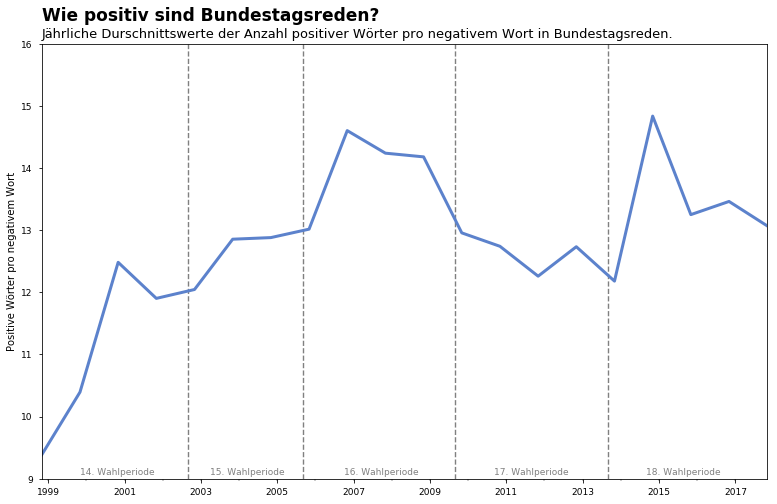

In [53]:
import matplotlib
import matplotlib.pyplot as plt


%matplotlib inline

matplotlib.style.use('seaborn-paper')


timeline_plot = sentiment_df.resample("12M").mean()["Relation_Positive_per_Negative"].plot(color="#5C82CC",linewidth=3)
timeline_plot.set_xlabel("Jahr")
timeline_plot.set_ylabel("Positive Wörter pro negativem Wort",size=10)
timeline_plot.set_ylim(9,16)
timeline_plot.figure.set_size_inches(13,8)
timeline_plot.tick_params(labelsize=9)
xmin, xmax = timeline_plot.get_xlim()
ymin, ymax = timeline_plot.get_ylim()
timeline_plot.xaxis.label.set_visible(False)

plt.figtext(.125,0.92,'Wie positiv sind Bundestagsreden?', fontsize=17, ha='left', weight="bold")
plt.figtext(.125,.89,"Jährliche Durschnittswerte der Anzahl positiver Wörter pro negativem Wort in Bundestagsreden.", fontsize=13, ha='left')


ymin, ymax = timeline_plot.get_ylim()
timeline_plot.vlines(x=period_end_list ,ymin=ymin,ymax = ymax,linestyles="dashed",color="gray")


plt.text(358, 9.07, "14. Wahlperiode", size=9, color="gray")
plt.text(399, 9.07, "15. Wahlperiode", size=9, color="gray")
plt.text(441, 9.07, "16. Wahlperiode", size=9, color="gray")
plt.text(488, 9.07, "17. Wahlperiode", size=9, color="gray")
plt.text(536, 9.07, "18. Wahlperiode", size=9, color="gray")

plt.savefig('PositivePerNegative_Jährlich.png',bbox_inches="tight")

Die vertikalen grauen Linien markieren das Ende einer Wahlperiode. Bei der Betrachtung des Verlaufs sticht besonders die schlechtere Stimmung in der 14. und 17. Wahlperiode heraus. Im Vergleich zu den anderen drei Zeiträumen scheint hier das durchschnittliche Verhältnis von positiven Wörtern pro negativem Wort wesentlich niedriger gewesen zu sein. Gleichzeitig zeigt der Trend von der 14. bis inklusive der 16. Wahlperiode nach oben, die Stimmung fängt also auf niedrigem Stand an und erholt sich im weiteren Verlauf etwas. Der negative Trendverlauf, der Ende der 16. Wahlperiode beginnt und sich über die gesamte 17. Wahlperiode fortsetzt, spiegelt vermutlich vor allem die Eurokrise wider, die 2009 ihren Anfang nahm.

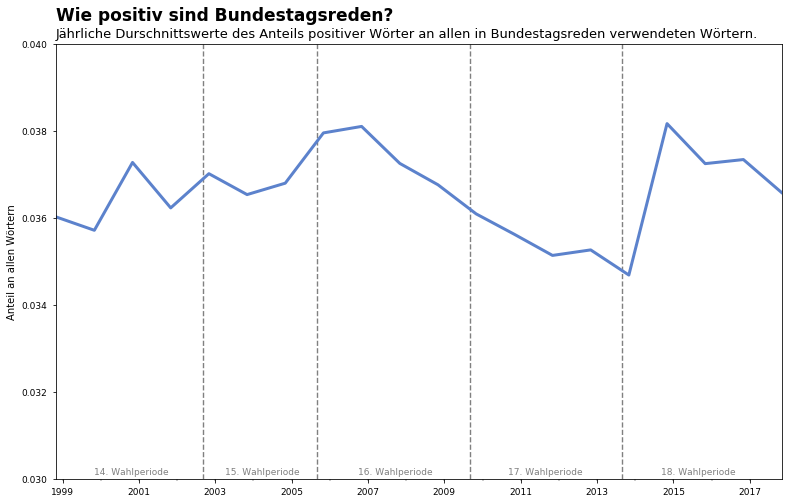

In [54]:
timeline_plot = sentiment_df.resample("12M").mean()["Proportion_Positive_Words"].plot(color="#5C82CC",linewidth=3)
timeline_plot.set_xlabel("Jahr")
timeline_plot.set_ylabel("Anteil an allen Wörtern",size=10)
timeline_plot.set_ylim(0.03,0.04)
timeline_plot.figure.set_size_inches(13,8)
timeline_plot.tick_params(labelsize=9)
xmin, xmax = timeline_plot.get_xlim()
ymin, ymax = timeline_plot.get_ylim()
timeline_plot.xaxis.label.set_visible(False)

plt.figtext(.125,0.92,'Wie positiv sind Bundestagsreden?', fontsize=17, ha='left', weight="bold")
plt.figtext(.125,.89,"Jährliche Durschnittswerte des Anteils positiver Wörter an allen in Bundestagsreden verwendeten Wörtern.", fontsize=13, ha='left')


ymin, ymax = timeline_plot.get_ylim()
timeline_plot.vlines(x=period_end_list ,ymin=ymin,ymax = ymax,linestyles="dashed",color="gray")


plt.text(358, 0.0301, "14. Wahlperiode", size=9, color="gray")
plt.text(399, 0.0301, "15. Wahlperiode", size=9, color="gray")
plt.text(441, 0.0301, "16. Wahlperiode", size=9, color="gray")
plt.text(488, 0.0301, "17. Wahlperiode", size=9, color="gray")
plt.text(536, 0.0301, "18. Wahlperiode", size=9, color="gray")

plt.savefig('ProportionPositive_Jährlich.png',bbox_inches="tight")

Die Darstellung des Anteils positiver Wörtern an der Gesamtzahl aller Wörter in den Reden macht den zuvor besprochenen Trend in der 17. Wahlperiode deutlicher. Bereits Mitte der 16. Wahlperiode nimmt die Menge positiver Wörter in Bundestagsreden ab und erreicht Ende der 17./ Anfang der 18. Wahlperiode den tiefsten Wert im gesamten dargestellten Zeitraum. 

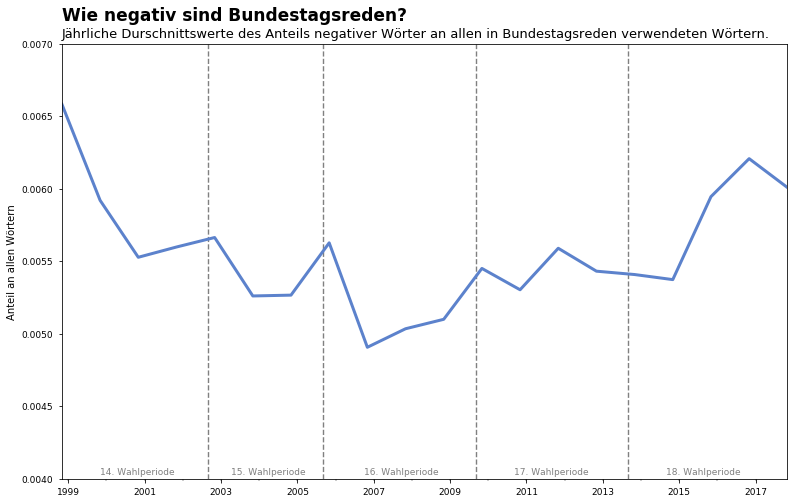

In [55]:
timeline_plot = sentiment_df.resample("12M").mean()["Proportion_Negative_Words"].plot(color="#5C82CC",linewidth=3)
timeline_plot.set_xlabel("Jahr")
timeline_plot.set_ylabel("Anteil an allen Wörtern",size=10)
timeline_plot.set_ylim(0.004,0.007)
timeline_plot.figure.set_size_inches(13,8)
timeline_plot.tick_params(labelsize=9)
xmin, xmax = timeline_plot.get_xlim()
ymin, ymax = timeline_plot.get_ylim()
timeline_plot.xaxis.label.set_visible(False)

plt.figtext(.125,0.92,'Wie negativ sind Bundestagsreden?', fontsize=17, ha='left', weight="bold")
plt.figtext(.125,.89,"Jährliche Durschnittswerte des Anteils negativer Wörter an allen in Bundestagsreden verwendeten Wörtern.", fontsize=13, ha='left')


ymin, ymax = timeline_plot.get_ylim()
timeline_plot.vlines(x=period_end_list ,ymin=ymin,ymax = ymax,linestyles="dashed",color="gray")


plt.text(358, 0.00403, "14. Wahlperiode", size=9, color="gray")
plt.text(399, 0.00403, "15. Wahlperiode", size=9, color="gray")
plt.text(441, 0.00403, "16. Wahlperiode", size=9, color="gray")
plt.text(488, 0.00403, "17. Wahlperiode", size=9, color="gray")
plt.text(536, 0.00403, "18. Wahlperiode", size=9, color="gray")

plt.savefig('ProportionNegative_Jährlich.png',bbox_inches="tight")

Der Anteil negativer Wörter weist einen leicht U-förmigen Verlauf auf. Die 14. Wahlperiode beginnt relativ negativ, über die 15. und 16. Wahlperiode nimmt der Anteil dann jedoch ab und erreicht Mitte der 16. Wahlperiode seinen tiefsten Punkt. Um 2009 setzt dann ein gegenläufiger Trend ein (Eurokrise), der in der 18. Wahlperiode dann nochmal einen deutlichen Sprung nach oben vollzieht.

Als nächstes betrachten wir die Sentimentverteilung detailierter und differenzieren zwischen Parteien und Wahlperioden.

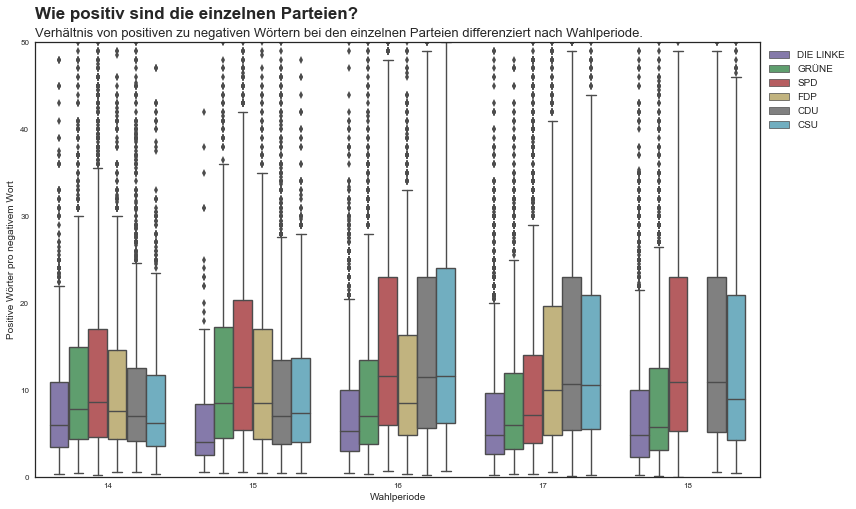

In [62]:
import seaborn as sns

muted_color = sns.color_palette("muted")
set1 = sns.color_palette("deep", n_colors=8)

sns.set_style("white")

#sns.set(font_scale=1.1)
fig, ax = plt.subplots(figsize=(13,8))

boxpl = sns.boxplot(x="Wahlperiode", y="Relation_Positive_per_Negative", hue="Party", data=sentiment_df,ax=ax,palette={"SPD":set1[2] ,"CDU":"grey","DIE LINKE": set1[3],"GRÜNE":set1[1],"FDP":set1[4],"CSU":set1[5]},hue_order=["DIE LINKE","GRÜNE","SPD","FDP","CDU","CSU"])
boxpl.set_ylim(0,50)
boxpl.set_ylabel("Positive Wörter pro negativem Wort", size=10)
boxpl.set_xlabel("Wahlperiode", size=10)
#boxpl.set_title("Wieviele positive Wörter kommen pro negativem Wort in einer Bundestagsrede vor?\nSentiment-Verteilung pro Wahlperiode und differenziert nach Parteien",size=19)

plt.figtext(.125,0.92,'Wie positiv sind die einzelnen Parteien?', fontsize=17, ha='left', weight="bold")
plt.figtext(.125,.89,"Verhältnis von positiven zu negativen Wörtern bei den einzelnen Parteien differenziert nach Wahlperiode.", fontsize=13, ha='left')

plt.legend(bbox_to_anchor=(1, 1),fontsize=10)


fig = boxpl.get_figure()
fig.savefig("sentiment_boxplots_positive_per_negative_german_Period.png",bbox_inches="tight") 

Bei dieser Darstellung sticht sofort die Trennlinie zwischen Regierungs-/Oppositionssprache ins Auge: Anhand der Stimmungsverteilung der einzelnen Parteien lässt sich leicht ablesen, wer an der Regierung beteiligt war und wer nicht. Während in der 14. und 15. Wahlperiode  vor allem die SPD mit großen Anteilen im höheren positiven Bereich auffällt, sind dies auch die einzigen Wahlperioden, in der die Grünen eine positivere Verteilung als die CDU und die CSU aufweisen. In der 16. und 18. Wahlperiode sind es dann SPD, CDU und CSU, deren Mediane mit Abstand den höchsten Wert aufweisen. Spannend dabei ist auch, dass die FDP die "positivste" Oppositionspartei zu sein scheint: In ihren drei Oppositions-Wahlperioden sind Median und Anteil an höheren Werten größer, als bei den Reden, die Grüne und Linkspartei aus der Rolle der Opposition heraus halten.

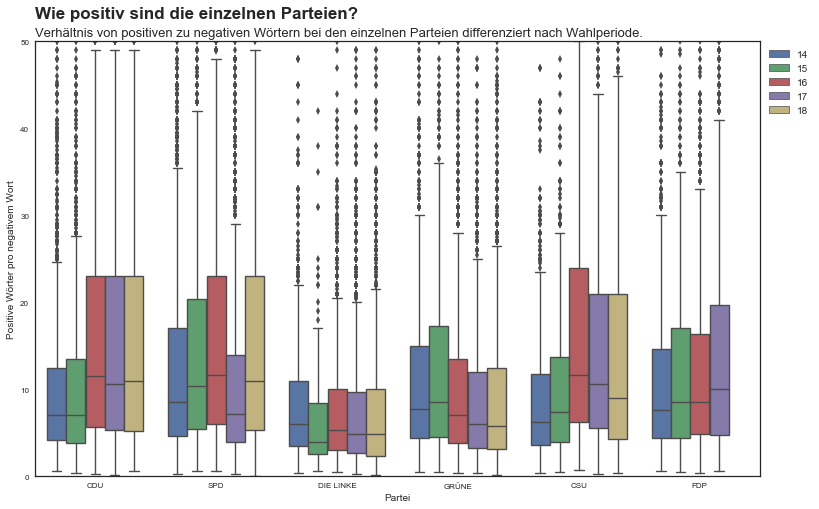

In [64]:
sns.set_style("white")

muted_color = sns.color_palette("muted")
set1 = sns.color_palette("deep", n_colors=8)

#sns.set(font_scale=1.1)
fig, ax = plt.subplots(figsize=(13,8))

boxpl = sns.boxplot(x="Party", y="Relation_Positive_per_Negative", hue="Wahlperiode", data=sentiment_df,ax=ax,palette=set1)
boxpl.set_ylim(0,50)
boxpl.set_ylabel("Positive Wörter pro negativem Wort",size=10)
boxpl.set_xlabel("Partei",size=10)
#boxpl.set_title("Wieviele positive Wörter kommen pro negativem Wort in einer Bundestagsrede vor?\nSentiment-Verteilung pro Wahlperiode und differenziert nach Parteien",size=19)

plt.figtext(.125,0.92,'Wie positiv sind die einzelnen Parteien?', fontsize=17, ha='left', weight="bold")
plt.figtext(.125,.89,"Verhältnis von positiven zu negativen Wörtern bei den einzelnen Parteien differenziert nach Wahlperiode.", fontsize=13, ha='left')

plt.legend(bbox_to_anchor=(1, 1),fontsize=10)


fig = boxpl.get_figure()
fig.savefig("sentiment_boxplots_positive_per_negative_german_Partei.png",bbox_inches="tight") 

Gruppiert nach Partei und diese differenziert nach Wahlperiode sieht man den Effekt, den die Regierungs- oder Oppositionsrolle auf die Stimmung der gehaltenen Reden haben, besonders klar. Bei der SPD fällt die 17. Wahlperiode, bei CDU und CSU die 14. und 15. Wahlperiode aus dem Rahmen. Die Grünen sind logischerweise in ihren Oppositionsjahren (Periode 16.- 18.) negativer, als in den beiden Wahlperioden zuvor, zeigen darüber hinaus aber auch in ihren Oppositionsjahren einen leichten negativen Trend. Spannenderweise lässt sich auch ein Trend zu etwas weniger positivem Sentiment in den Regierungsjahren der CSU beobachten. SPD und CDU erscheinen dagegen relativ konstant in der Sentimentverteilung während ihrer Regierungsbeteiligung.